#**Heart Attack Risk**

**Problem Definition** : How do different factors affect the risk of heart attack among individuals?

**Goal** : To leverage machine learning to accurately assess the risk of heart attacks for individuals using the different factors from the dataset

In [ ]:
import pandas as pd
import seaborn as sb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pydotplus
from IPython.display import Image

sb.set()



In [ ]:
ol = pd.read_csv('heart.csv')
ol.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [ ]:
ol.shape

(8763, 26)

In [ ]:
ol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

##**Cleaning of Data**

>



###Blood Pressure is given in pairs with the upper value refering to Systolic Blood Pressure while the lower one is referring to Diastolic Blood Pressure

In [ ]:
split_data = ol["Blood Pressure"].str.split("/", expand = True)

ol["Systolic_BP"] = split_data[0]
ol["Diastolic_BP"] = split_data[1]

ol["Systolic_BP"] = ol["Systolic_BP"].astype("int64")
ol["Diastolic_BP"] = ol["Diastolic_BP"].astype("int64")


In [ ]:
threshold = 1.5
for var in ol.select_dtypes(include=['number']):
    if ol[var].nunique() > 2:  # Check if the variable has more than 2 unique values
        numeric_values = ol[(ol[var] != 0) & (ol[var] != 1)][var]  # Exclude 0 and 1
        Q1s = numeric_values.quantile(0.25)
        Q3s = numeric_values.quantile(0.75)
        IQRs = Q3s - Q1s
        outliers = numeric_values[(numeric_values < (Q1s - threshold * IQRs)) | (numeric_values > (Q3s + threshold * IQRs))]
        print("Number of outliers for", var, ":", len(outliers))


Number of outliers for Age : 0
Number of outliers for Cholesterol : 0
Number of outliers for Heart Rate : 0
Number of outliers for Exercise Hours Per Week : 0
Number of outliers for Stress Level : 0
Number of outliers for Sedentary Hours Per Day : 0
Number of outliers for Income : 0
Number of outliers for BMI : 0
Number of outliers for Triglycerides : 0
Number of outliers for Physical Activity Days Per Week : 0
Number of outliers for Sleep Hours Per Day : 0
Number of outliers for Systolic_BP : 0
Number of outliers for Diastolic_BP : 0


In [ ]:
a=ol.drop(['Patient ID','Country','Hemisphere','Blood Pressure'],axis = 1)
a

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Continent,Heart Attack Risk,Systolic_BP,Diastolic_BP
0,67,Male,208,72,0,0,1,0,0,4.168189,...,6.615001,261404,31.251233,286,0,6,South America,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,...,4.963459,285768,27.194973,235,1,7,North America,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,...,9.463426,235282,28.176571,587,4,4,Europe,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,...,7.648981,125640,36.464704,378,3,4,North America,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,...,1.514821,160555,21.809144,231,1,5,Asia,0,91,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,61,1,1,1,0,1,7.917342,...,10.806373,235420,19.655895,67,7,7,Asia,0,94,76
8759,28,Female,120,73,1,0,0,1,0,16.558426,...,3.833038,217881,23.993866,617,4,9,North America,0,157,102
8760,47,Male,250,105,0,1,1,1,1,3.148438,...,2.375214,36998,35.406146,527,4,4,South America,1,161,75
8761,36,Male,178,60,1,0,1,0,0,3.789950,...,0.029104,209943,27.294020,114,2,8,South America,0,119,67


In [ ]:
a.shape


(8763, 24)

#**Visualisation of Data**

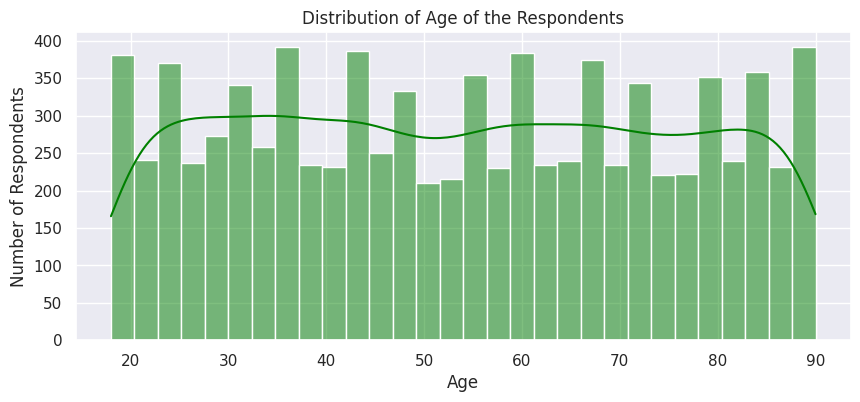

In [ ]:
old = pd.DataFrame(a['Age'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, x='Age', bins=30, kde=True, color='green')
plt.xlabel('Age')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Age of the Respondents')
plt.show()

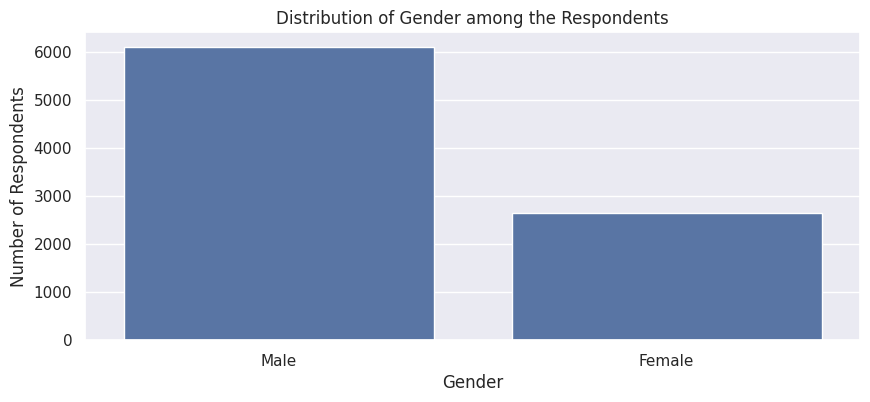

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Sex')
plt.xlabel('Gender')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Gender among the Respondents')
plt.show()

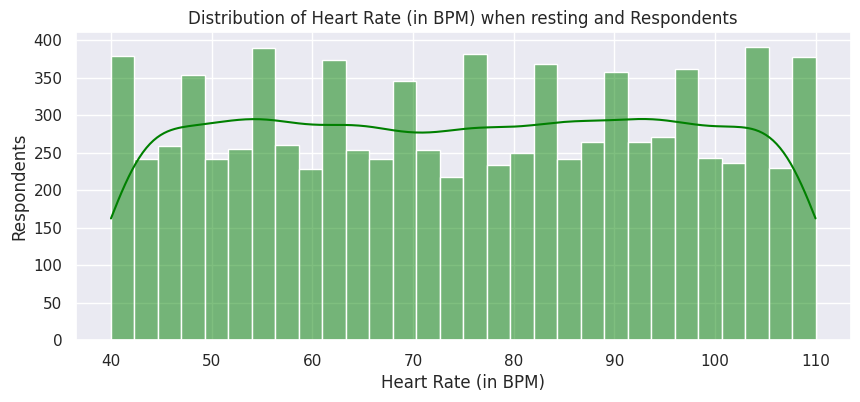

In [ ]:
plt.figure(figsize=(10, 4))
sb.histplot(data=a, x='Heart Rate', bins = 30, kde=True, color='green')
plt.xlabel('Heart Rate (in BPM)')
plt.ylabel('Respondents')
plt.title('Distribution of Heart Rate (in BPM) when resting and Respondents')
plt.show()

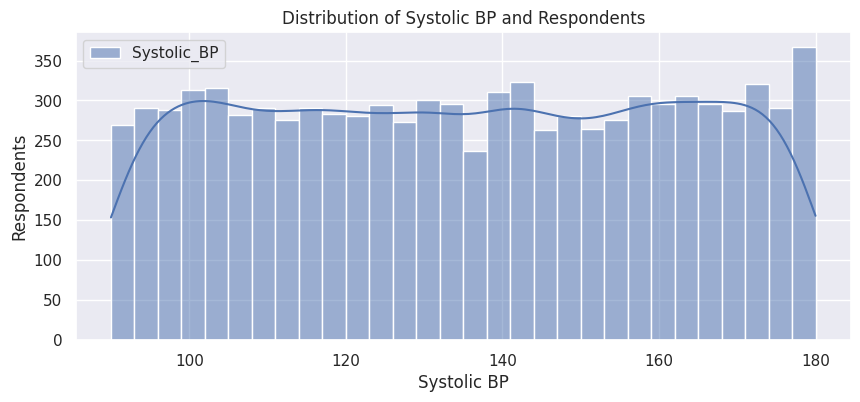

In [ ]:
old = pd.DataFrame(a['Systolic_BP'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, bins=30, kde=True, color='green')
plt.xlabel('Systolic BP')
plt.ylabel('Respondents')
plt.title('Distribution of Systolic BP and Respondents')
plt.show()

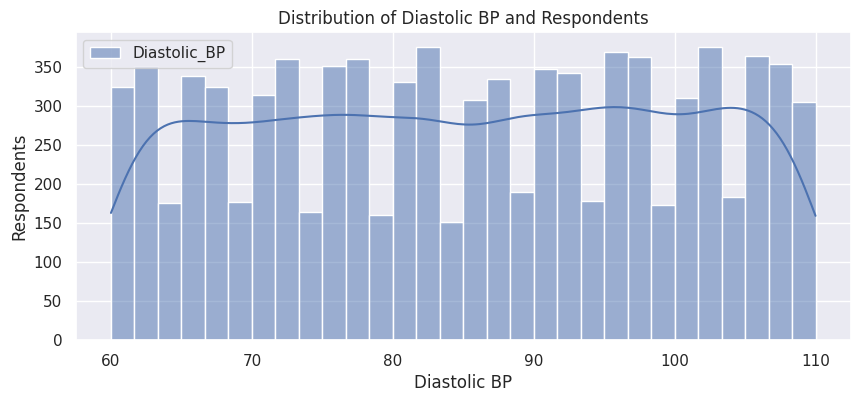

In [ ]:
old = pd.DataFrame(a['Diastolic_BP'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, bins=30, kde=True, color='green')
plt.xlabel('Diastolic BP')
plt.ylabel('Respondents')
plt.title('Distribution of Diastolic BP and Respondents')
plt.show()

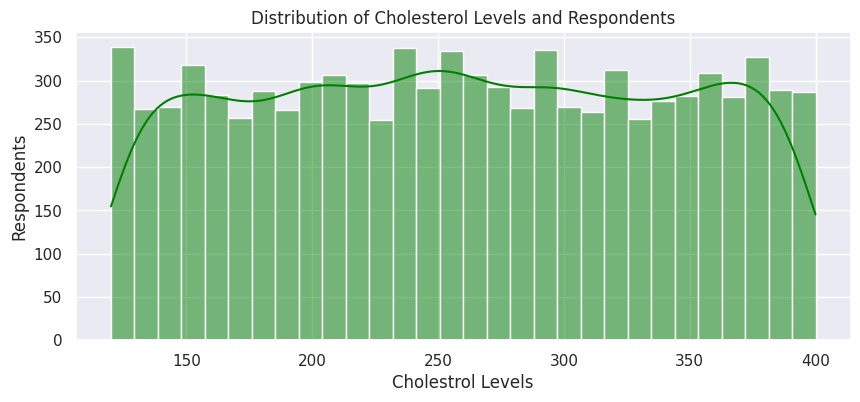

In [ ]:
old = pd.DataFrame(a['Cholesterol'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, x='Cholesterol', bins=30, kde=True, color='green')
plt.xlabel('Cholestrol Levels')
plt.ylabel('Respondents')
plt.title('Distribution of Cholesterol Levels and Respondents')
plt.show()

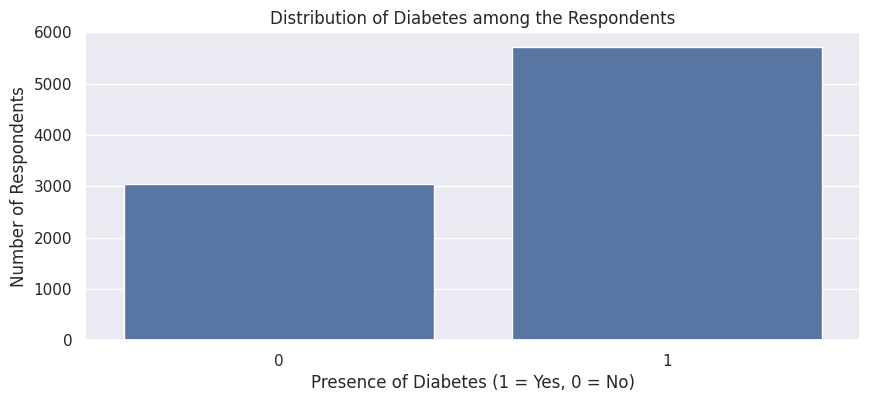

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Diabetes')
plt.xlabel('Presence of Diabetes (1 = Yes, 0 = No)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Diabetes among the Respondents')
plt.show()

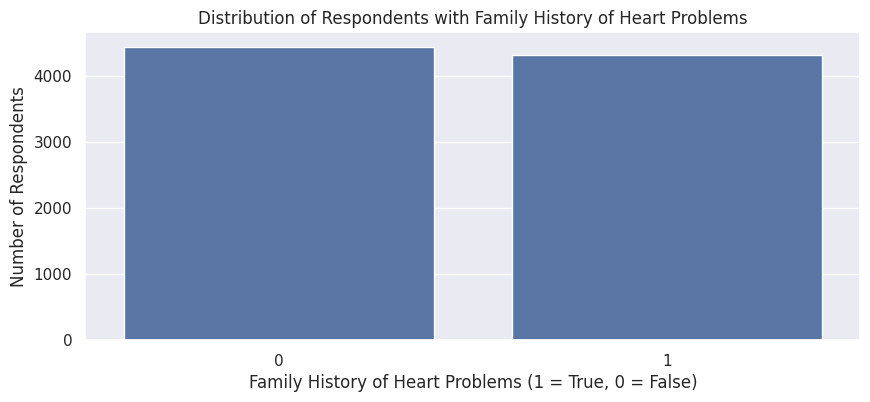

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Family History')
plt.xlabel('Family History of Heart Problems (1 = True, 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Respondents with Family History of Heart Problems')
plt.show()

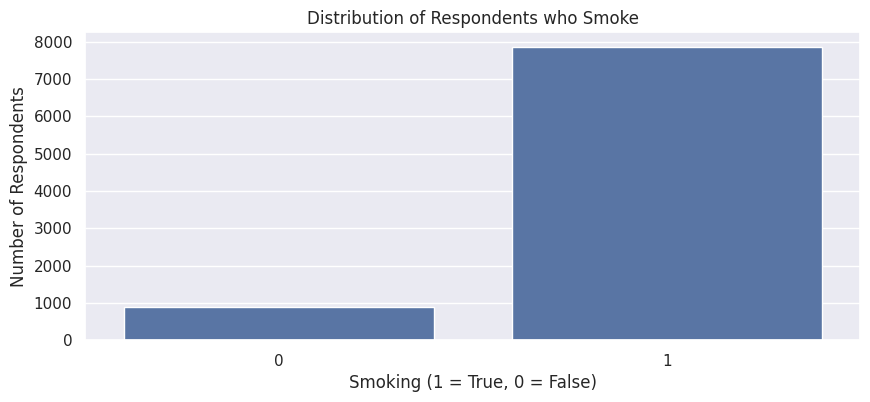

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Smoking')
plt.xlabel('Smoking (1 = True, 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Respondents who Smoke')
plt.show()

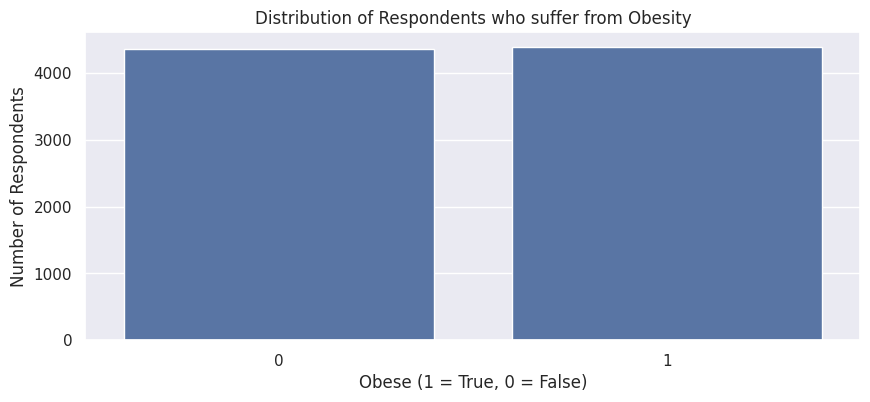

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Obesity')
plt.xlabel('Obese (1 = True, 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Respondents who suffer from Obesity')
plt.show()

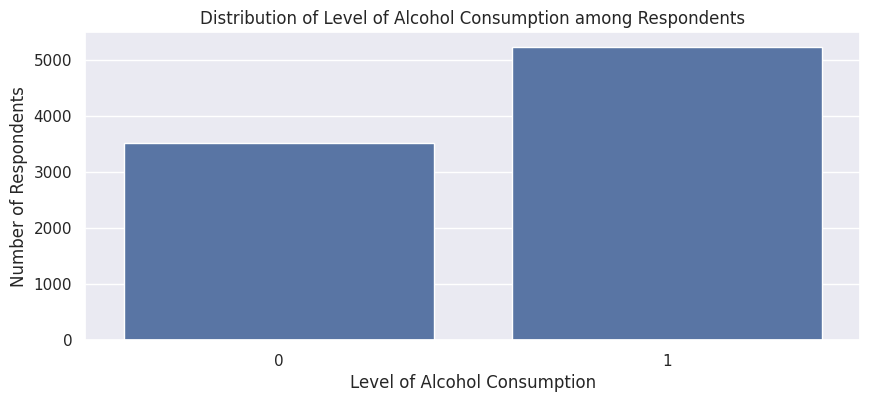

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Alcohol Consumption')
plt.xlabel('Level of Alcohol Consumption')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Level of Alcohol Consumption among Respondents')
plt.show()

Text(0.5, 1.0, 'Distribution of Exercise Hours Per Week among the Respondents')

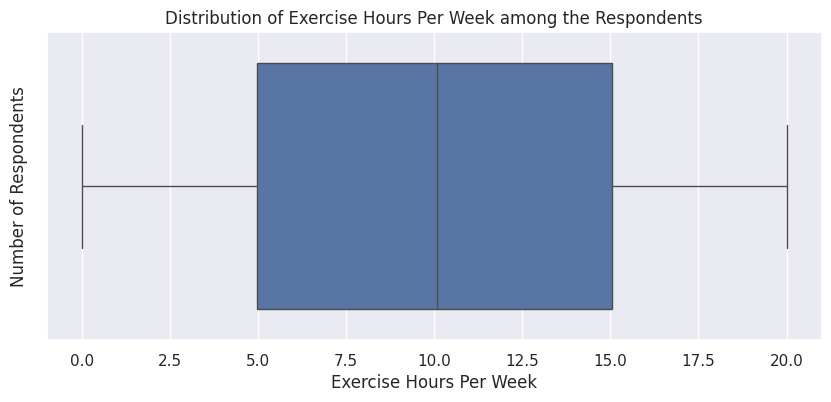

In [ ]:
plt.figure(figsize=(10, 4))
sb.boxplot(data = a['Exercise Hours Per Week'], orient = "h")
plt.xlabel('Exercise Hours Per Week')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Exercise Hours Per Week among the Respondents')

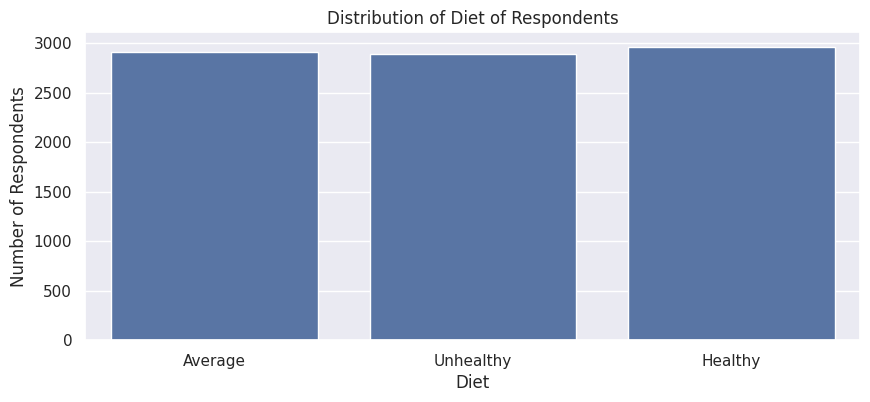

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Diet')
plt.xlabel('Diet')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Diet of Respondents')
plt.show()

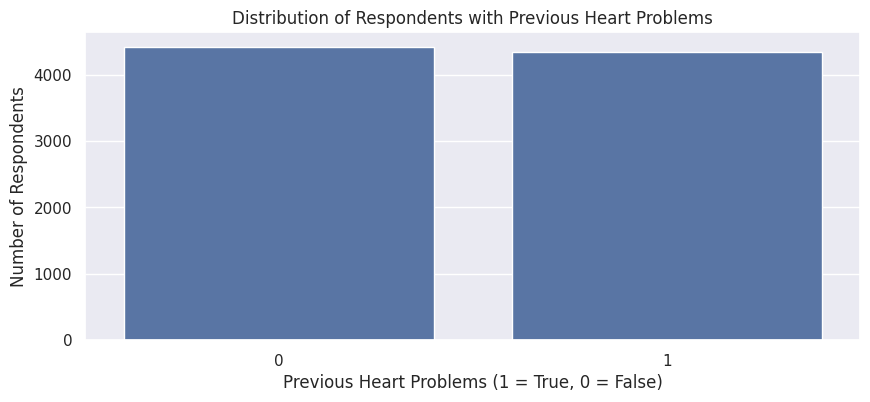

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Previous Heart Problems')
plt.xlabel('Previous Heart Problems (1 = True, 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Respondents with Previous Heart Problems')
plt.show()

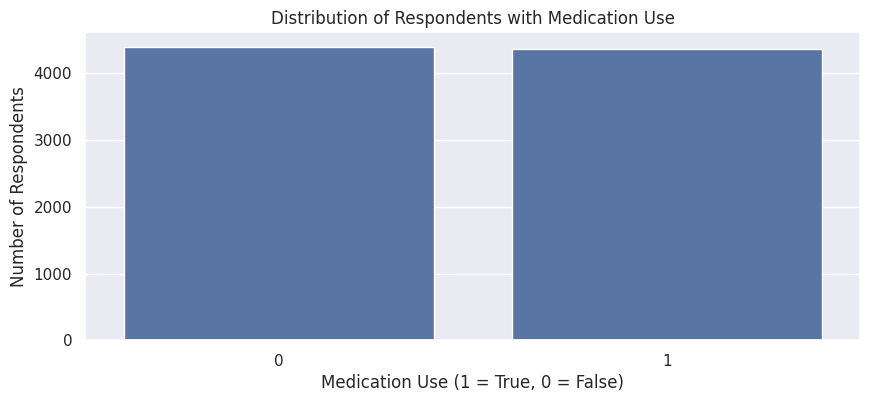

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Medication Use')
plt.xlabel('Medication Use (1 = True, 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Respondents with Medication Use')
plt.show()

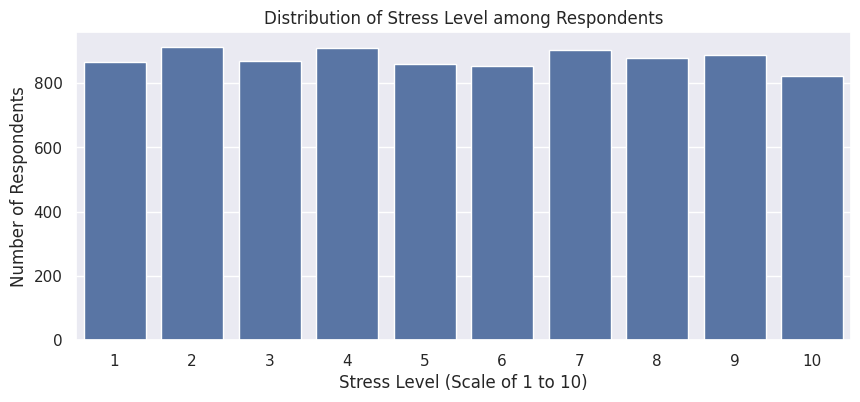

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Stress Level')
plt.xlabel('Stress Level (Scale of 1 to 10)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Stress Level among Respondents')
plt.show()

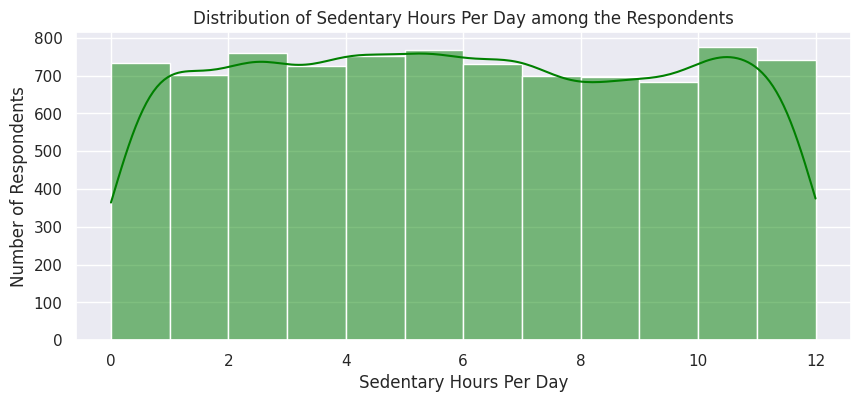

In [ ]:
old = pd.DataFrame(a['Sedentary Hours Per Day'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, x='Sedentary Hours Per Day', bins=12, kde=True, color='green')
plt.xlabel('Sedentary Hours Per Day')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Sedentary Hours Per Day among the Respondents')
plt.show()

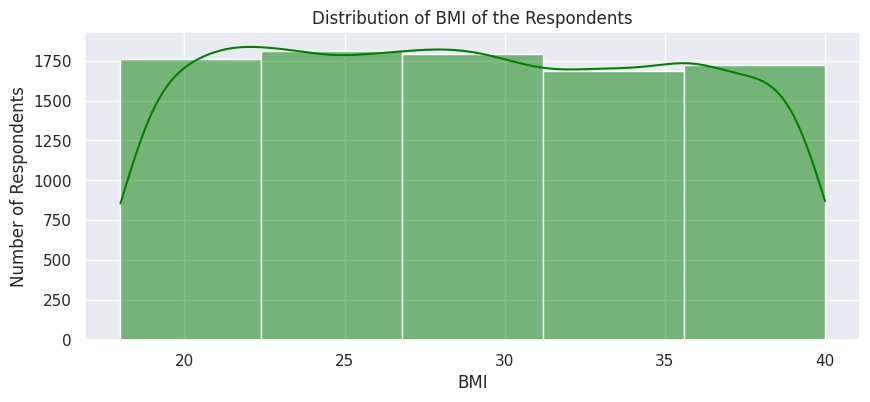

In [ ]:
old = pd.DataFrame(a['BMI'])
plt.figure(figsize=(10, 4))
sb.histplot(data=old, x='BMI', bins=5, kde=True, color='green')
plt.xlabel('BMI')
plt.ylabel('Number of Respondents')
plt.title('Distribution of BMI of the Respondents')
plt.show()

Text(0.5, 1.0, 'Distribution of Income of the Respondents')

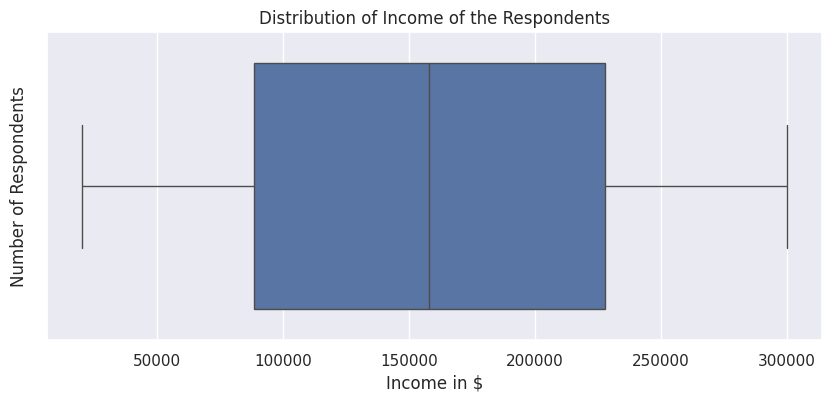

In [ ]:
plt.figure(figsize=(10, 4))
sb.boxplot(data = a['Income'], orient = "h")
plt.xlabel('Income in $')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Income of the Respondents')

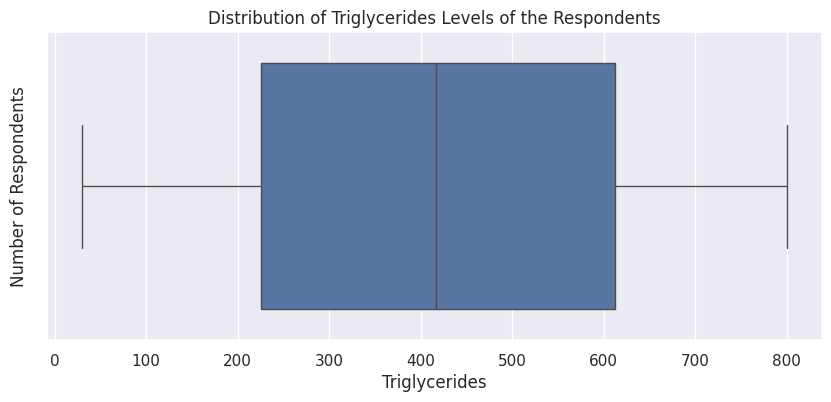

In [ ]:
plt.figure(figsize=(10, 4))
sb.boxplot(data = a['Triglycerides'], orient = "h")
plt.xlabel('Triglycerides')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Triglycerides Levels of the Respondents')
plt.show()

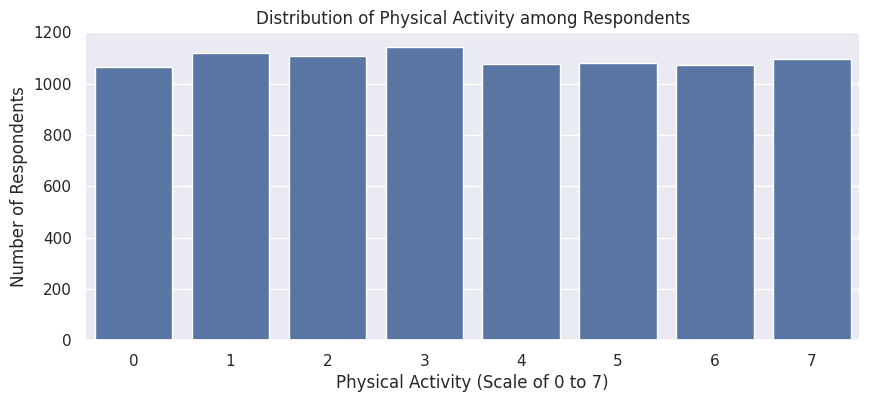

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Physical Activity Days Per Week')
plt.xlabel('Physical Activity (Scale of 0 to 7)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Physical Activity among Respondents')
plt.show()

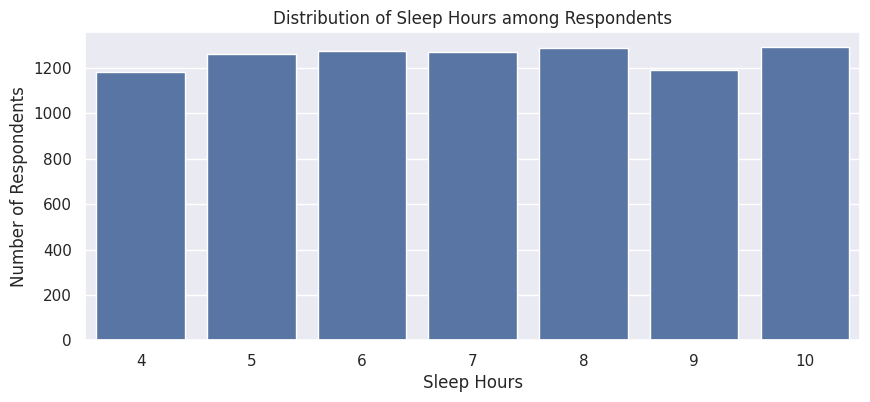

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Sleep Hours Per Day')
plt.xlabel('Sleep Hours')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Sleep Hours among Respondents')
plt.show()

<ipython-input-96-e75cadad9a0f>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


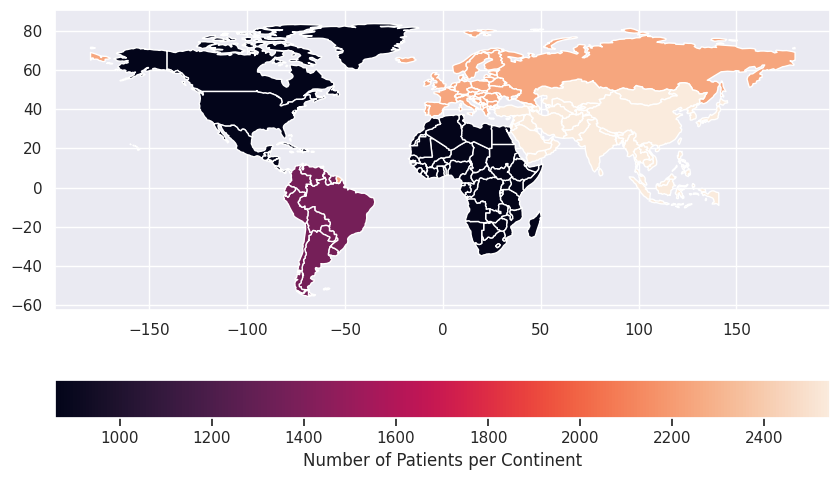

In [ ]:
import geopandas as gpd

continent_count = a['Continent'].value_counts()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(
    pd.DataFrame(list(continent_count.items()), columns=['continent', 'count']),
    how='left', left_on='continent', right_on='continent'
)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(column='count', ax=ax, legend=True,
           legend_kwds={'label': "Number of Patients per Continent", 'orientation': "horizontal"})
plt.show()

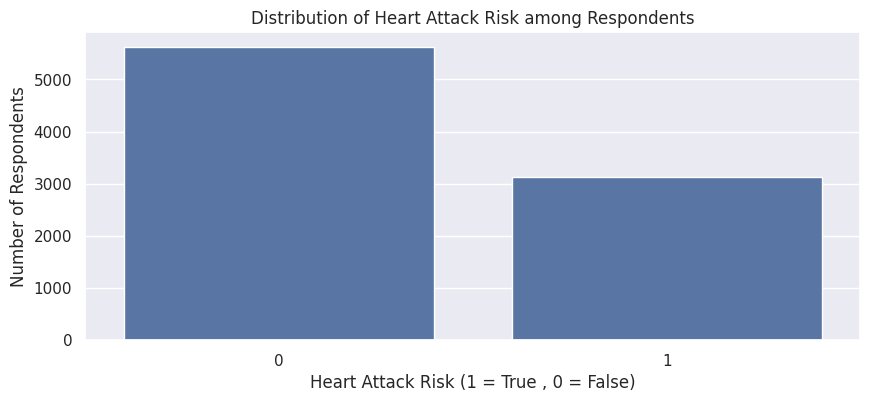

In [ ]:
plt.figure(figsize=(10, 4))
sb.countplot(data=a, x='Heart Attack Risk')
plt.xlabel('Heart Attack Risk (1 = True , 0 = False)')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Heart Attack Risk among Respondents')
plt.show()

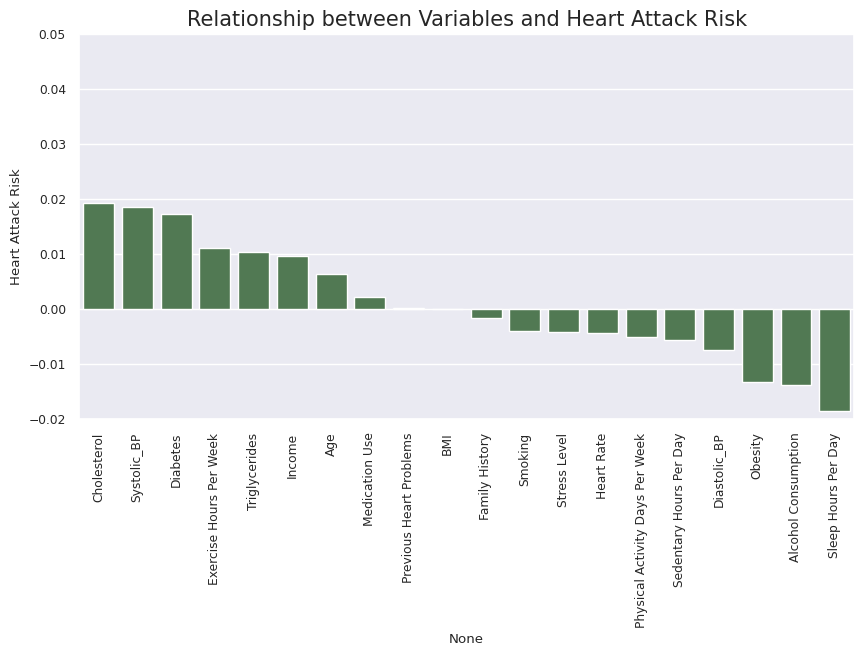

In [ ]:
numeric_columns = a.select_dtypes(include='number')
corr_heartrisk = numeric_columns.corr()["Heart Attack Risk"]
corr_heartrisk = corr_heartrisk.drop("Heart Attack Risk", axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sb.set(font_scale=0.8)
sb.barplot(x=corr_heartrisk.index, y=corr_heartrisk, color="#4a804d")
plt.xticks(rotation=90)
plt.ylim(-0.02, 0.05)
plt.title("Relationship between Variables and Heart Attack Risk", fontsize=15)
plt.show()

#**Classification of Variables into Sub-Groups**

**DEMOGRAPHICS**

In [ ]:
demographics = a[['Age', 'Sex', 'Income', 'Heart Attack Risk']].copy()
demographics.loc[:, 'Sex'] = demographics['Sex'].replace({'Male': 1, 'Female': 0})
demographics

,Age,Sex,Income,Heart Attack Risk
0,67,1,261404,0
1,21,1,285768,0
2,21,0,235282,0
3,84,1,125640,0
4,66,1,160555,0
...,...,...,...,...
8758,60,1,235420,0
8759,28,0,217881,0
8760,47,1,36998,1
8761,36,1,209943,0


**DEMOGRAPHICS HEATMAP**

<Axes: >

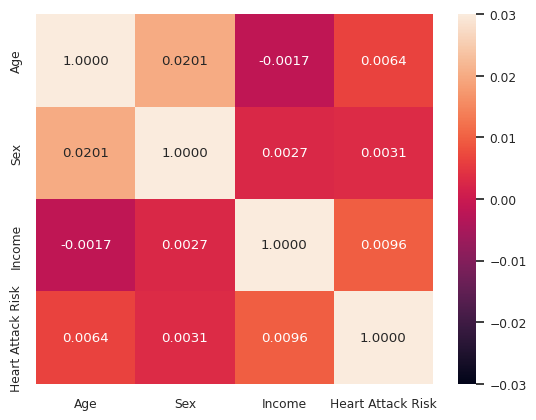

In [ ]:
sb.heatmap(demographics.corr(),vmin=-0.03,vmax=0.03,annot=True,fmt=".4f")

**HEALTH STATUS**

In [ ]:
health_status = a[['BMI', 'Heart Rate','Diastolic_BP','Systolic_BP','Heart Attack Risk']]
health_status

,BMI,Heart Rate,Diastolic_BP,Systolic_BP,Heart Attack Risk
0,31.251233,72,88,158,0
1,27.194973,98,93,165,0
2,28.176571,72,99,174,0
3,36.464704,73,100,163,0
4,21.809144,93,88,91,0
...,...,...,...,...,...
8758,19.655895,61,76,94,0
8759,23.993866,73,102,157,0
8760,35.406146,105,75,161,1
8761,27.294020,60,67,119,0


**HEALTH STATUS HEATMAP**

<Axes: >

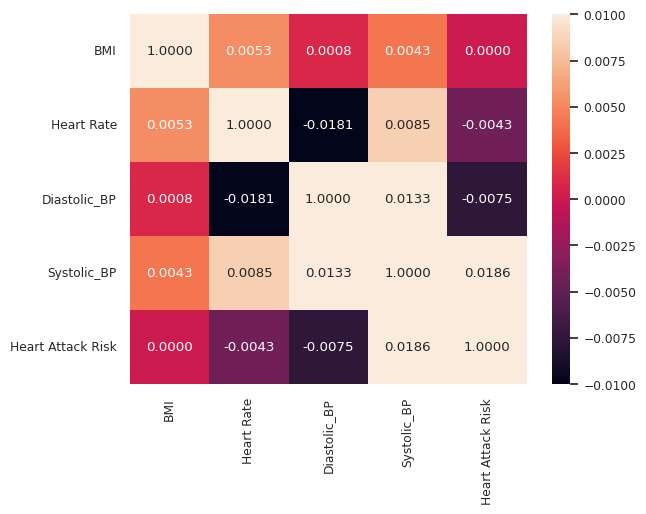

In [ ]:
sb.heatmap(health_status.corr(),vmin=-0.01,vmax=0.01,annot=True,fmt=".4f")

**RISK FACTORS**

In [ ]:
risk_factors = a[['Cholesterol','Diabetes', 'Obesity', 'Triglycerides', 'Heart Attack Risk']]
risk_factors

,Cholesterol,Diabetes,Obesity,Triglycerides,Heart Attack Risk
0,208,0,0,286,0
1,389,1,1,235,0
2,324,1,0,587,0
3,383,1,0,378,0
4,318,1,1,231,0
...,...,...,...,...,...
8758,121,1,0,67,0
8759,120,1,1,617,0
8760,250,0,1,527,1
8761,178,1,0,114,0


**RISK FACTORS HEATMAP**

<Axes: >

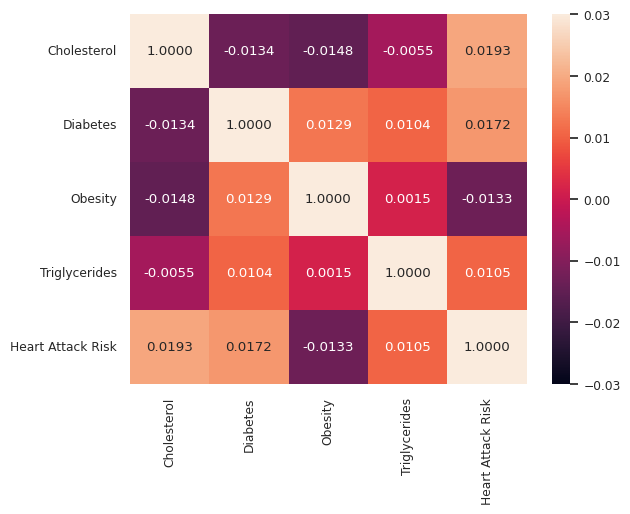

In [ ]:
sb.heatmap(risk_factors.corr(),vmin=-0.03,vmax=0.03,annot=True,fmt=".4f")

**MEDICAL HISTORY**

In [ ]:
medical_history = a[['Previous Heart Problems', 'Medication Use','Heart Attack Risk']]
medical_history

,Previous Heart Problems,Medication Use,Heart Attack Risk
0,0,0,0
1,1,0,0
2,1,1,0
3,1,0,0
4,1,0,0
...,...,...,...
8758,1,1,0
8759,0,0,0
8760,1,0,1
8761,1,1,0


**MEDICAL HISTORY HEATMAP**

<Axes: >

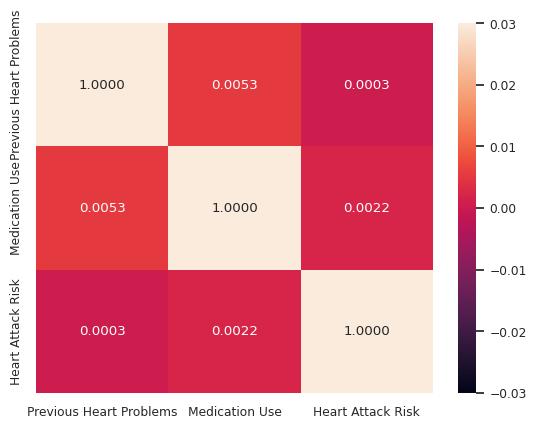

In [ ]:
sb.heatmap(medical_history.corr(),vmin=-0.03,vmax=0.03,annot=True,fmt=".4f")

#**Distribution of Factors against Heart Attack Risk**

**We chose one factor from each grouping with the highest correlation to heart attack risk**


*   Income
*   Systolic Blood Pressure
*   Cholestrol
*   Medication Use





**INCOME**

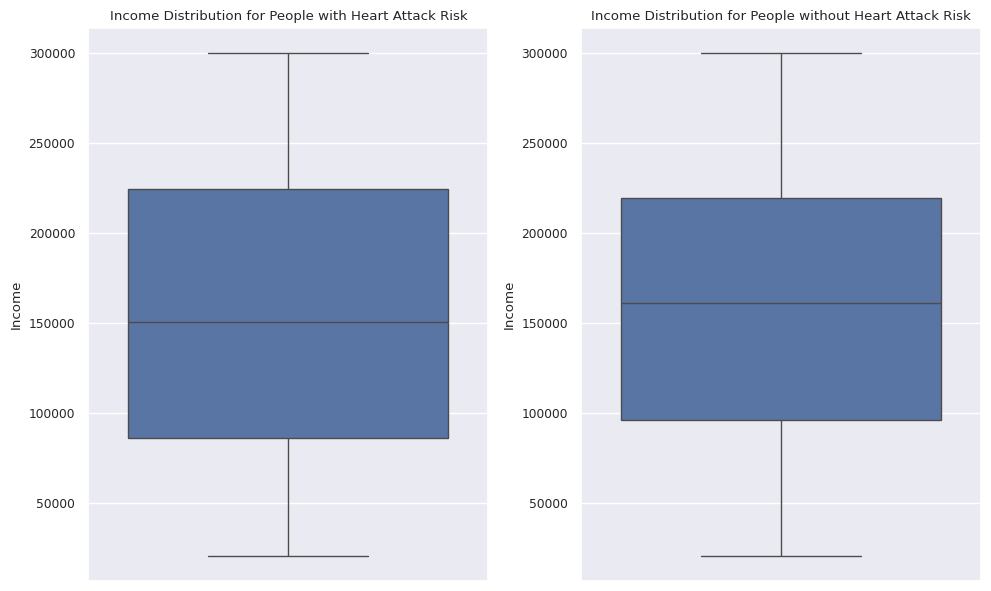

In [ ]:
np.random.seed(42)
sample_size = 500
risk_present_sample = a[a['Heart Attack Risk'] == 1].sample(sample_size, random_state=42)
risk_absent_sample = a[a['Heart Attack Risk'] == 0].sample(sample_size, random_state=42)

# Create box plots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sb.boxplot(y='Income', data=risk_present_sample)
plt.title('Income Distribution for People with Heart Attack Risk')

plt.subplot(1, 2, 2)
sb.boxplot(y='Income', data=risk_absent_sample)
plt.title('Income Distribution for People without Heart Attack Risk')

plt.tight_layout()
plt.show()

**SYSTOLIC BLOOD PRESSURE**

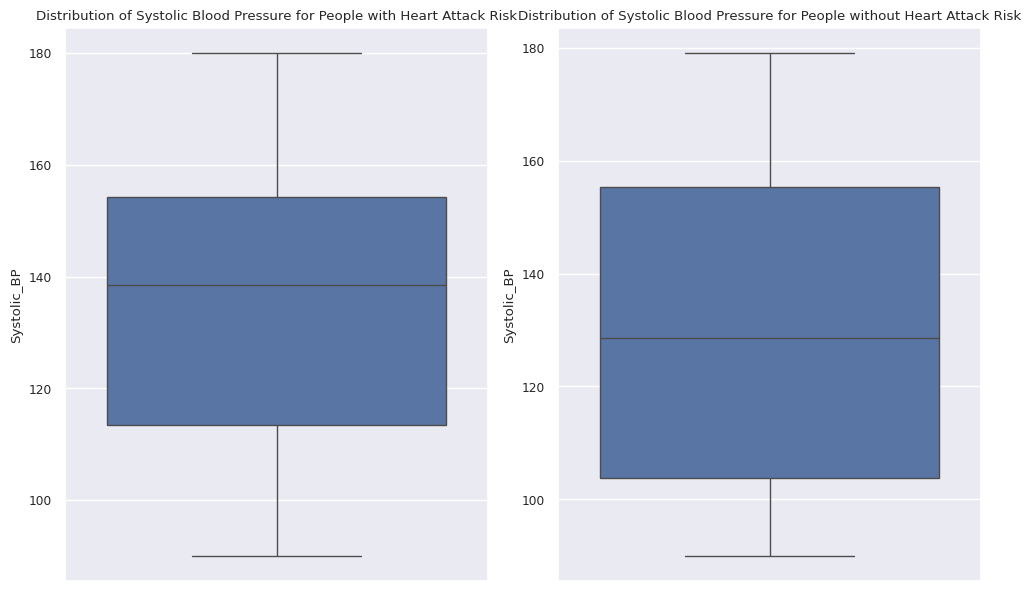

In [ ]:
np.random.seed(42)
sample_size = 100
risk_present_sample = a[a['Heart Attack Risk'] == 1].sample(sample_size, random_state=42)
risk_absent_sample = a[a['Heart Attack Risk'] == 0].sample(sample_size, random_state=42)

# Create box plots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sb.boxplot(y='Systolic_BP', data=risk_present_sample)
plt.title('Distribution of Systolic Blood Pressure for People with Heart Attack Risk')

plt.subplot(1, 2, 2)
sb.boxplot(y='Systolic_BP', data=risk_absent_sample)
plt.title('Distribution of Systolic Blood Pressure for People without Heart Attack Risk')

plt.tight_layout()
plt.show()

**CHOLESTEROL**

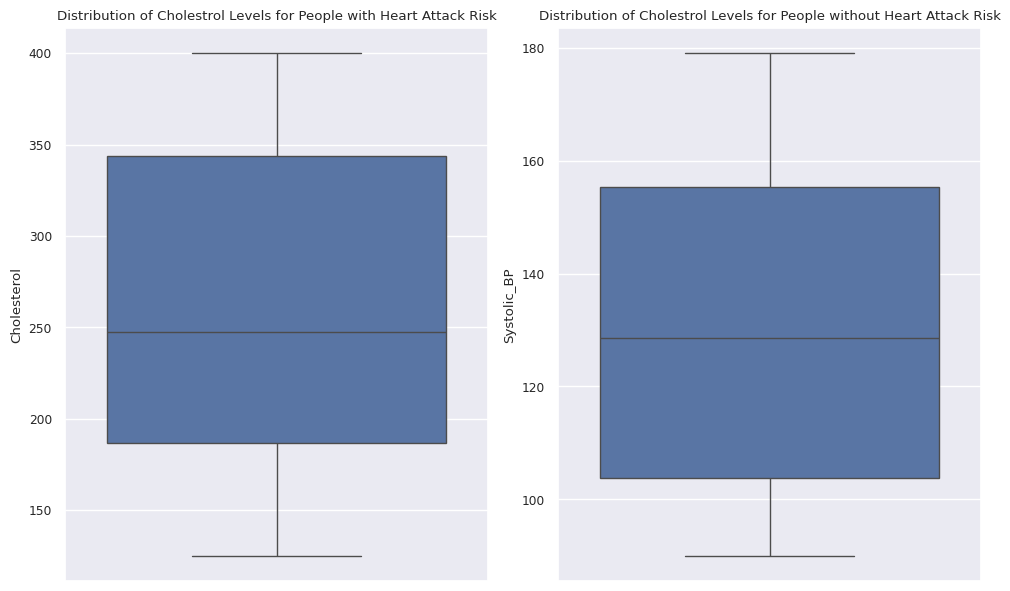

In [ ]:
np.random.seed(42)
sample_size = 100
risk_present_sample = a[a['Heart Attack Risk'] == 1].sample(sample_size, random_state=42)
risk_absent_sample = a[a['Heart Attack Risk'] == 0].sample(sample_size, random_state=42)

# Create box plots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sb.boxplot(y='Cholesterol', data=risk_present_sample)
plt.title('Distribution of Cholestrol Levels for People with Heart Attack Risk')

plt.subplot(1, 2, 2)
sb.boxplot(y='Systolic_BP', data=risk_absent_sample)
plt.title('Distribution of Cholestrol Levels for People without Heart Attack Risk')

plt.tight_layout()
plt.show()


**MEDICATION USE**

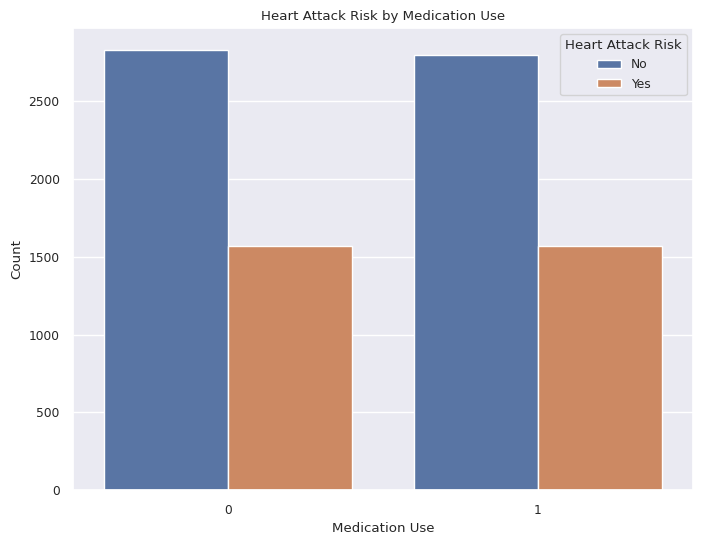

In [ ]:
plt.figure(figsize=(8, 6))
sb.countplot(x='Medication Use', hue='Heart Attack Risk', data=a)
plt.title('Heart Attack Risk by Medication Use')
plt.xlabel('Medication Use')
plt.ylabel('Count')
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()


#**Use Machine Learning to assess the risk of these factors on Heart Attack Risk**

## **Prediction using a Linear Regression Model**

###**Uni-Variate Linear Regression**

In [ ]:
def univariateLinearRegression(Xvar=None, yvar=None, df=None):
    # Extract Response and Predictors
    y = pd.DataFrame(df[yvar])
    X = pd.DataFrame(df[Xvar])

    # Split the 70/30 into random Train and Test (70:30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    print("Variable : ", Xvar)
    print("Train data set of :", X_train.shape, y_train.shape)
    print("Test data set :", X_test.shape, y_test.shape)

    linreg = LinearRegression()  # create the linear regression object
    linreg.fit(X_train, y_train)  # train the linear regression model

    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)

    # Plot the Linear Regression line for train and test data
    plt.figure(figsize=(16, 8))
    plt.scatter(X_train, y_train, color='blue', label='Train Actual')
    plt.scatter(X_train, y_train_pred, color='red', label='Train Predicted')
    plt.scatter(X_test, y_test, color='green', label='Test Actual')
    plt.scatter(X_test, y_test_pred, color='orange', label='Test Predicted')
    plt.plot(X_train, linreg.predict(X_train), color='gray', label='Regression line')
    plt.legend()
    plt.show()

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))


    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()


Variable :  Income
Train data set of : (6134, 1) (6134, 1)
Test data set : (2629, 1) (2629, 1)


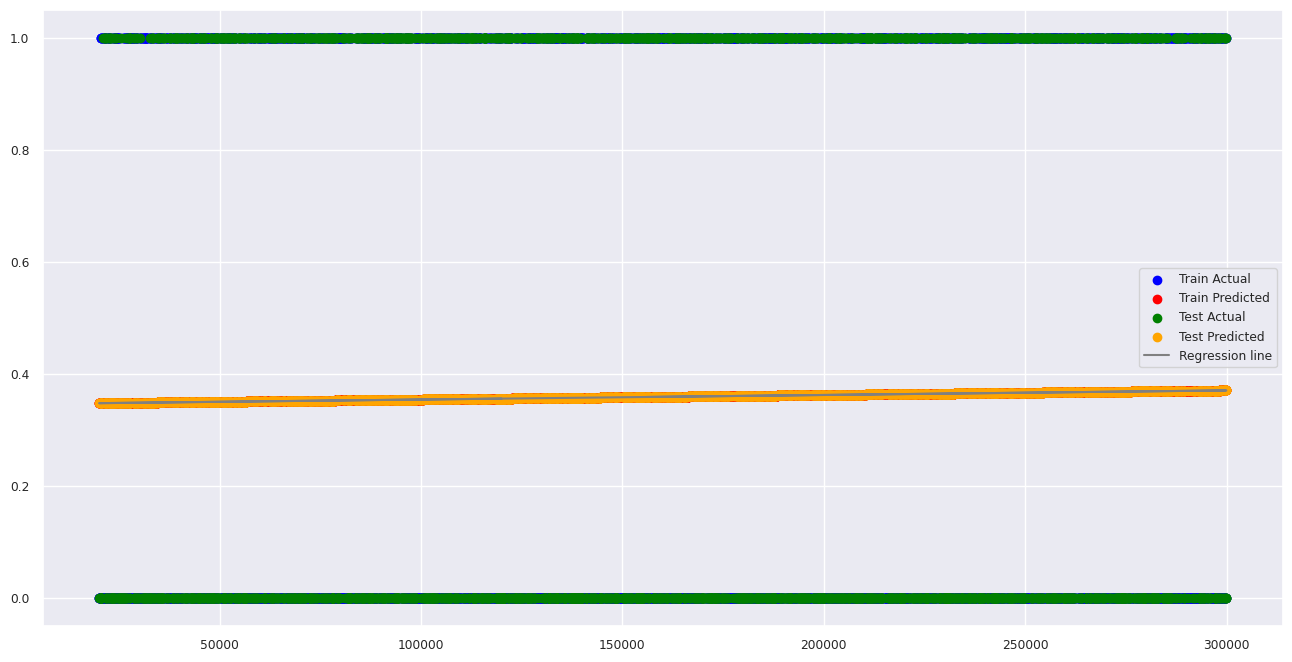

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.00018932190236231605
Mean Squared Error (MSE) 	: 0.23002456412548236
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.00020517591872848406
Mean Squared Error (MSE) 	: 0.22953788274375053

Variable :  Systolic_BP
Train data set of : (6134, 1) (6134, 1)
Test data set : (2629, 1) (2629, 1)


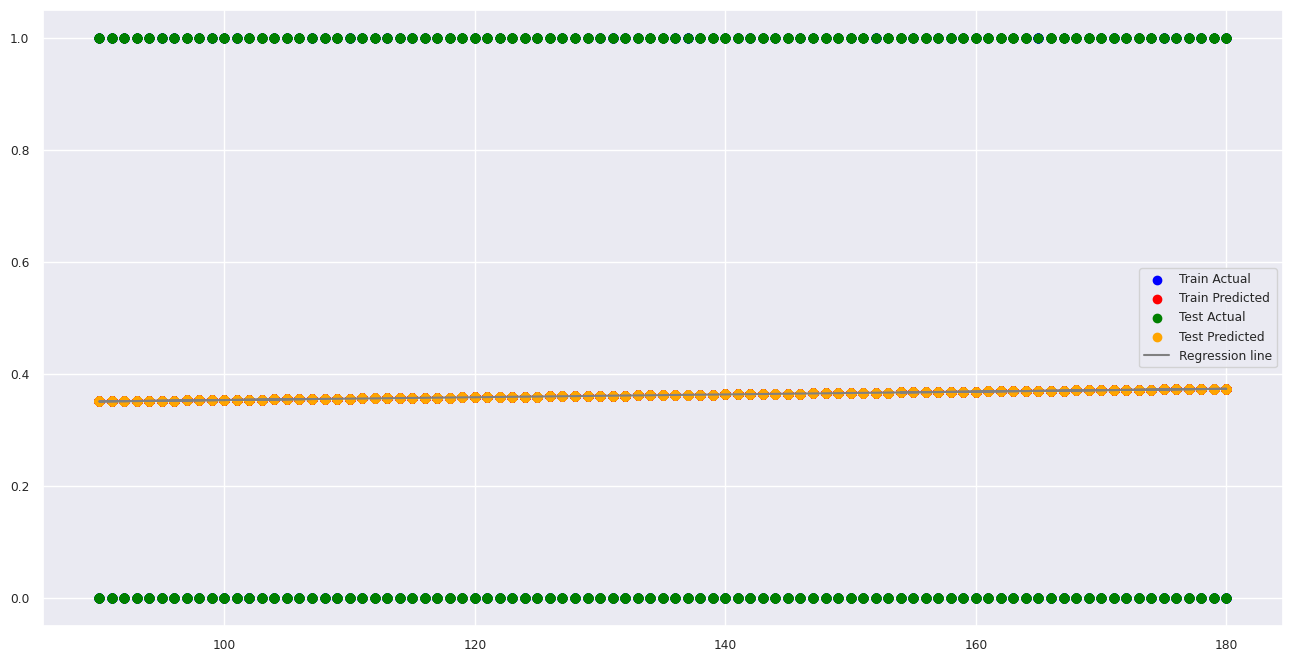

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0001915050213789904
Mean Squared Error (MSE) 	: 0.2308889107707678
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -4.221115936475783e-05
Mean Squared Error (MSE) 	: 0.22737817754348488

Variable :  Cholesterol
Train data set of : (6134, 1) (6134, 1)
Test data set : (2629, 1) (2629, 1)


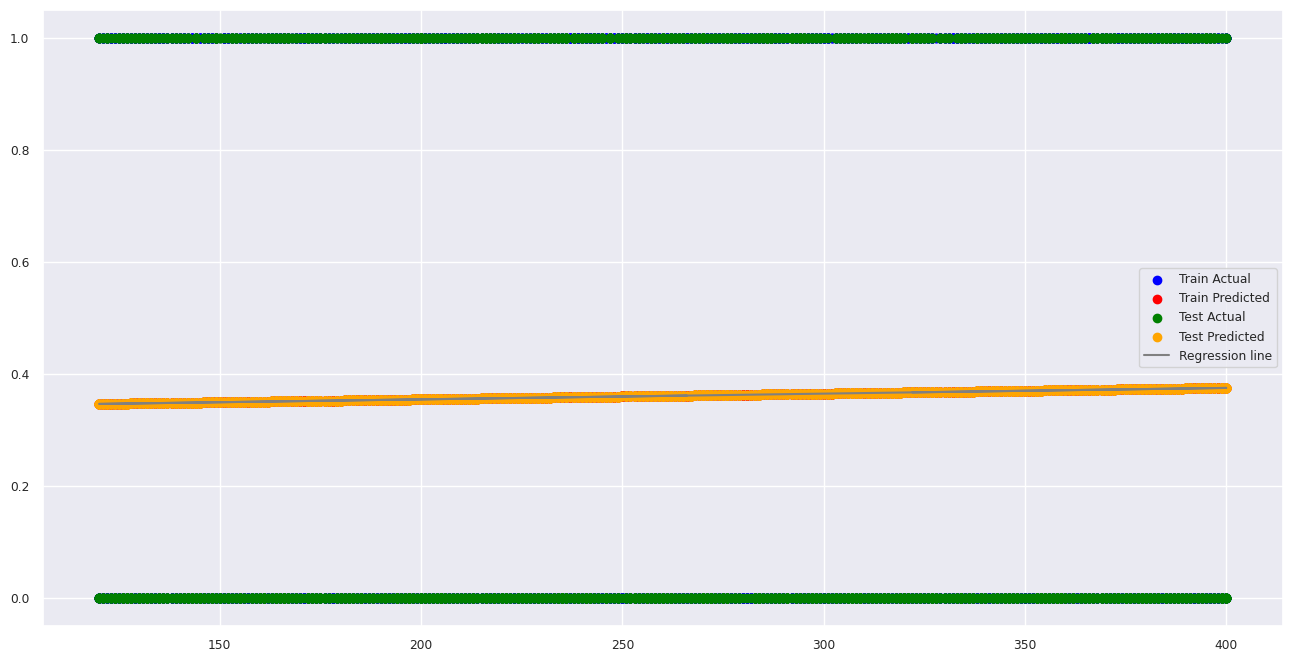

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.00029478830261076006
Mean Squared Error (MSE) 	: 0.23045782754532176
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.0002991798722145056
Mean Squared Error (MSE) 	: 0.22831853335476668

Variable :  Medication Use
Train data set of : (6134, 1) (6134, 1)
Test data set : (2629, 1) (2629, 1)


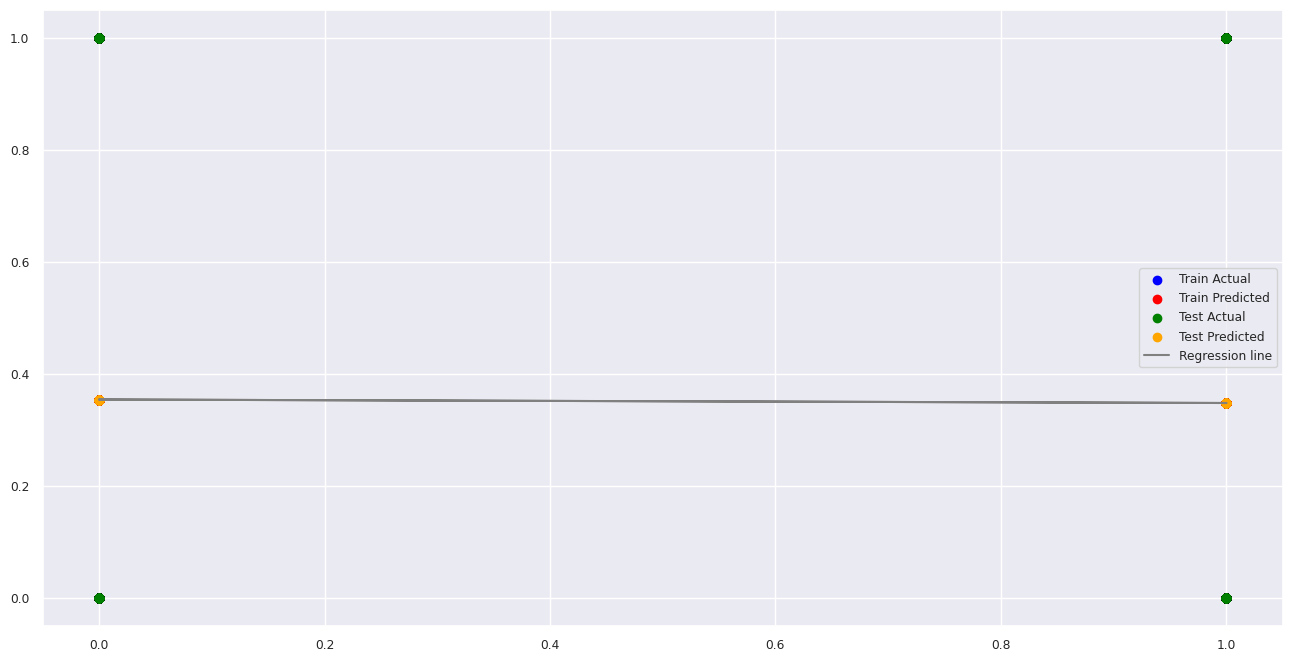

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 4.2885918302815185e-05
Mean Squared Error (MSE) 	: 0.22778757889383164
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.0028005841144906896
Mean Squared Error (MSE) 	: 0.23504330457329986



In [ ]:
univariateLinearRegression(Xvar = "Income", yvar = "Heart Attack Risk", df = a)
univariateLinearRegression(Xvar = "Systolic_BP", yvar = "Heart Attack Risk", df = a)
univariateLinearRegression(Xvar = "Cholesterol", yvar = "Heart Attack Risk", df = a)
univariateLinearRegression(Xvar = "Medication Use", yvar = "Heart Attack Risk", df = a)


**We found that linear regression is not a good choice for Heart Attack Risk which takes a binary value of 0 or 1 as it does not capture the complex non-linear relationships between predictors and binary outcomes.This is because linear regression assumes that the relationship between the independent variables and the dependent variable is linear. Linear regression works better for continuous variables rather than discontinuous variables such as Heart Attack Risk (0/1). However, when the dependent variable is binary, this assumption is not valid which leads to error in the interpretations of the coefficients of the dependent variables.**

##**Uni-variate Logistic Regression**

In [ ]:
def univariateLogisticRegression(Xvar=None, yvar=None, df=None):
    # Extract Response and Predictors
    y = df[yvar].values.ravel()  # Convert y to a 1d array
    X = pd.DataFrame(df[Xvar])

    # Split the 70/30 into random Train and Test (70:30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    print("Variable : ", Xvar)
    print("Train data set of :", X_train.shape, y_train.shape)
    print("Test data set :", X_test.shape, y_test.shape)

    # Create and fit logistic regression model
    logreg = LogisticRegression() # create the logistic regression object
    logreg.fit(X_train, y_train)  # train the logistic regression model

    # Predict Response corresponding to Predictors
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print accuracy
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Train Data')
    plt.scatter(X_test, y_test, color='green', label='Test Data')

    # Plot decision boundary
    x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_values = logreg.predict_proba(x_values)[:, 1]  # Probability of class 1
    plt.plot(x_values, y_values, color='red', label='Logistic Regression Decision Boundary')

    plt.xlabel(Xvar)
    plt.ylabel(yvar)
    plt.legend()
    plt.title('Logistic Regression')
    plt.show()

Variable :  Income
Train data set of : (6134, 1) (6134,)
Test data set : (2629, 1) (2629,)
Train Accuracy: 0.6410172807303554
Test Accuracy: 0.6435907189045265


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


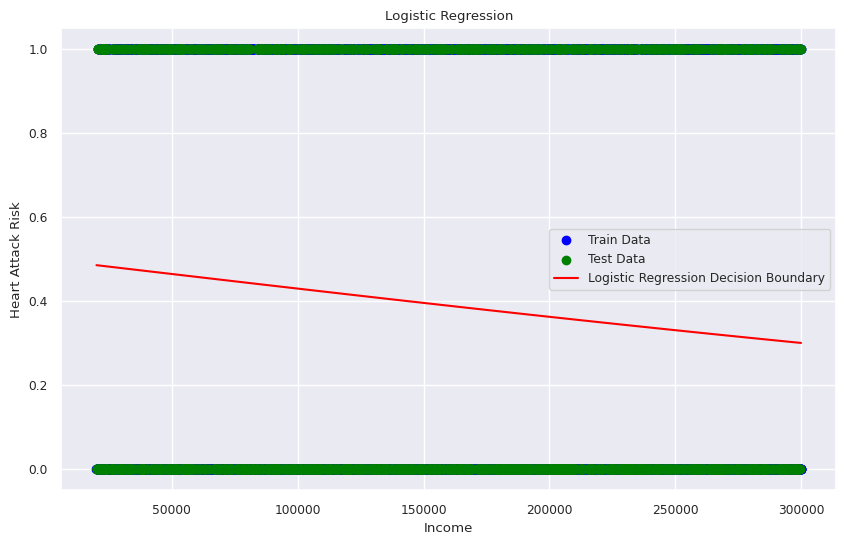


Variable :  Systolic_BP
Train data set of : (6134, 1) (6134,)
Test data set : (2629, 1) (2629,)
Train Accuracy: 0.6403651776980763
Test Accuracy: 0.6451122099657665


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


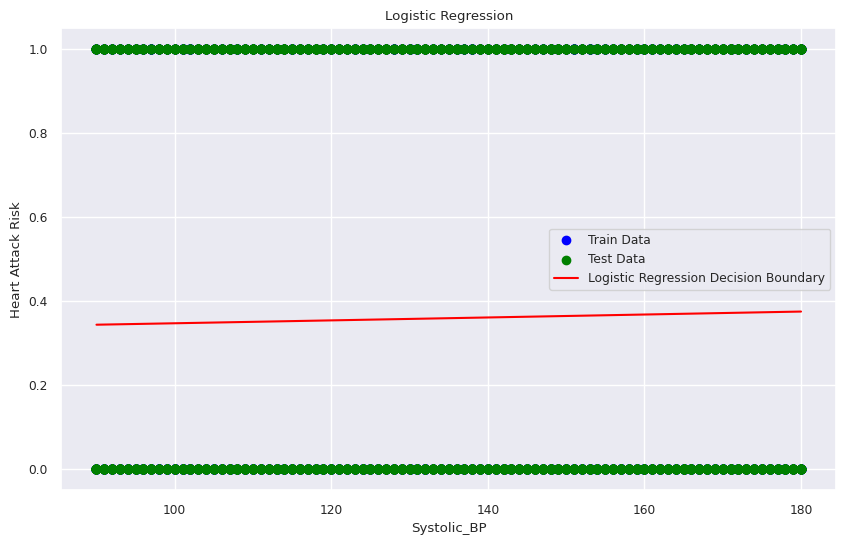


Variable :  Cholesterol
Train data set of : (6134, 1) (6134,)
Test data set : (2629, 1) (2629,)
Train Accuracy: 0.638408868601239
Test Accuracy: 0.6496766831494865


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


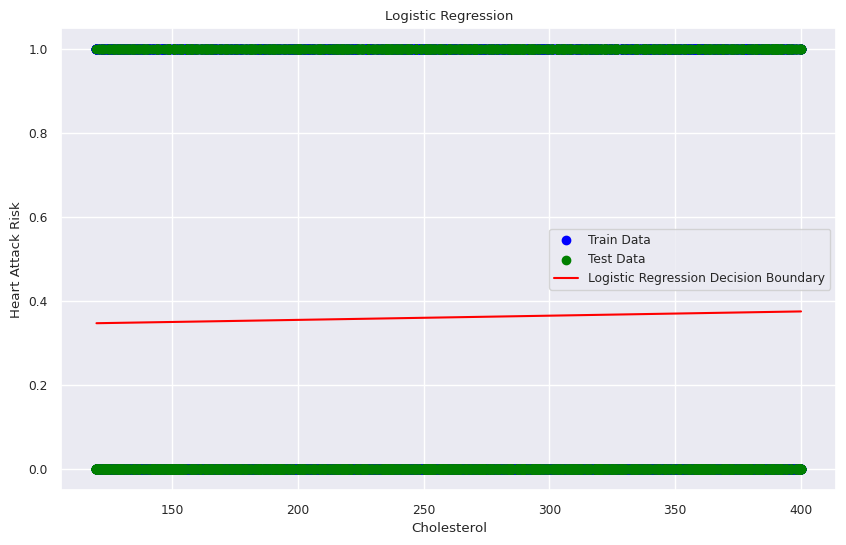


Variable :  Medication Use
Train data set of : (6134, 1) (6134,)
Test data set : (2629, 1) (2629,)
Train Accuracy: 0.6444408216498206
Test Accuracy: 0.6356028908330164


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


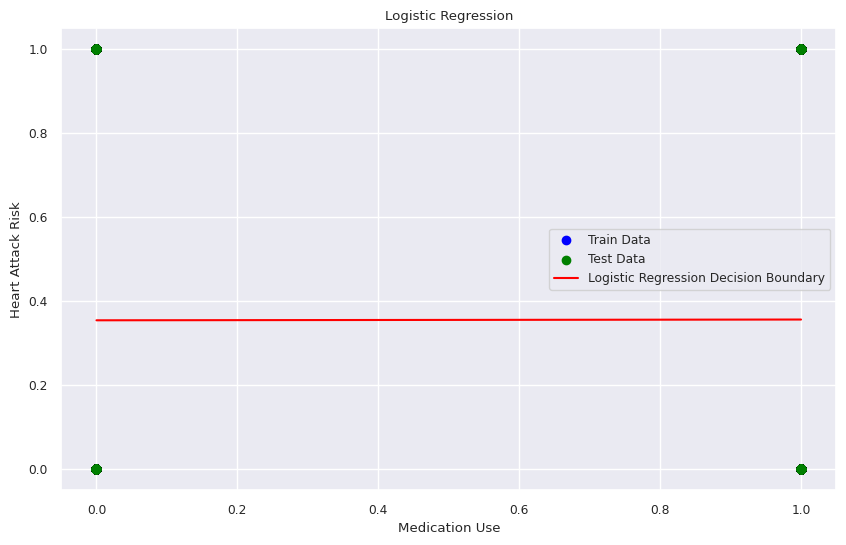

In [ ]:
univariateLogisticRegression(Xvar = "Income", yvar = "Heart Attack Risk", df = a)
print("")
univariateLogisticRegression(Xvar = "Systolic_BP", yvar = "Heart Attack Risk", df = a)
print("")
univariateLogisticRegression(Xvar = "Cholesterol", yvar = "Heart Attack Risk", df = a)
print("")
univariateLogisticRegression(Xvar = "Medication Use", yvar = "Heart Attack Risk", df = a)
print("")


##**Multi-variate Logistic Regression**

---



In [ ]:
def multivariateLogisticRegression(Xvar = None, Yvar = None, df = None):

    # DataFrame is named a
    # 'Heart Attack Risk' is the target variable
    # Select features and target variable
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print accuracy
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    # Evaluate the model using Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_test_pred)
    print("Mean Squared Error:", mse)


X = a[['Income','Systolic_BP','Cholesterol', 'Medication Use']]
y = a['Heart Attack Risk']

print("For multivariate data from Income, Systolic_BP, Cholesterol, Medication Use:")
multivariateLogisticRegression (X,y,a)


For multivariate data from Income, Systolic_BP, Cholesterol, Medication Use:
Train Accuracy: 0.6411803064884252
Test Accuracy: 0.6432103461392165
Mean Squared Error: 0.3567896538607836


##**Confusion Matrix Function**

---

In [ ]:
def confusionMatrix(Xvar=None, yvar=None, df=None):
    # Extract Response and Predictors
    dectree = DecisionTreeClassifier()
    y = pd.DataFrame(df[yvar])
    X = pd.DataFrame(df[Xvar])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    dectree.fit(X_train, y_train)

    print("Variable : ", Xvar)
    print("Train data set of :", X_train.shape, y_train.shape)
    print("Test data set :", X_test.shape, y_test.shape)

    # Predict the Response corresponding to Predictors
    y_train_pred = dectree.predict(X_train)

    # Print the Classification Accuracy For Train
    print("Train Data")
    print("Classification Accuracy  :\t", dectree.score(X_train, y_train))
    print()

    # Predict the Response corresponding to Predictors
    y_test_pred = dectree.predict(X_test)

    # Print the Classification Accuracy Test
    print("Test Data")
    print("Classification Accuracy  :\t", dectree.score(X_test, y_test))
    print()

    # Calculate confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)


    # Plot confusion matrix for test set
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test)')
    plt.show()

   # Calculate TPR and FPR for test set
    TP_test = cm_test[1, 1]
    FP_test = cm_test[0, 1]
    TN_test = cm_test[0, 0]
    FN_test = cm_test[1, 0]

    TPR_test = TP_test / (TP_test + FN_test)
    FPR_test = FP_test / (FP_test + TN_test)

    print("Confusion Matrix for Model (Test):")
    print(cm_test)
    print("True Positive Rate (TPR) for Model (Test):", TPR_test)
    print("False Positive Rate (FPR) for Model (Test):", FPR_test)
    print()


##**Random Forest Machine Learning**



Accuracy: 0.604031951312286
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      1691
           1       0.38      0.18      0.25       938

    accuracy                           0.60      2629
   macro avg       0.52      0.51      0.49      2629
weighted avg       0.55      0.60      0.56      2629

Variable :        Income  Systolic_BP  Cholesterol  Medication Use
0     261404          158          208               0
1     285768          165          389               0
2     235282          174          324               1
3     125640          163          383               0
4     160555           91          318               0
...      ...          ...          ...             ...
8758  235420           94          121               1
8759  217881          157          120               0
8760   36998          161          250               0
8761  209943          119          178               1
8762  247338          138   

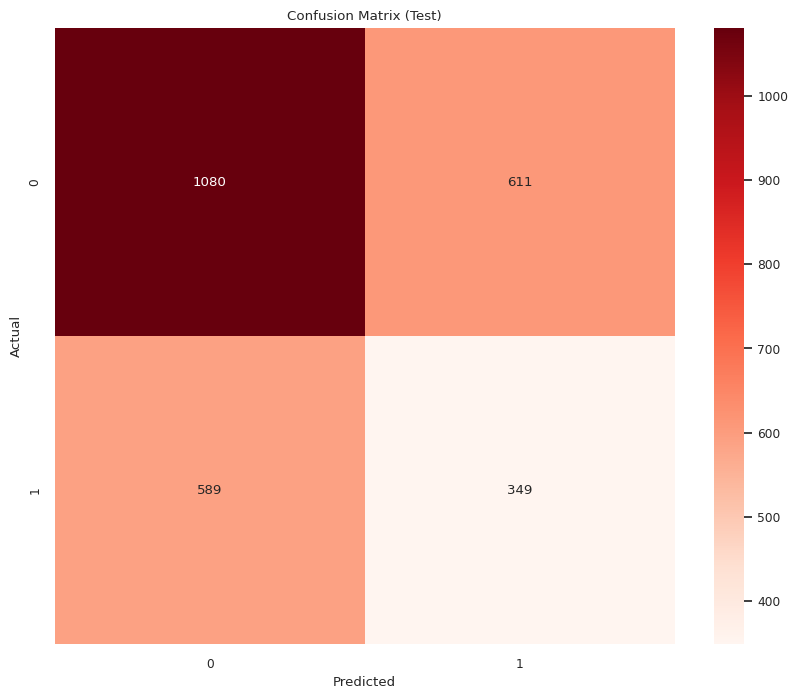

Confusion Matrix for Model (Test):
[[1080  611]
 [ 589  349]]
True Positive Rate (TPR) for Model (Test): 0.3720682302771855
False Positive Rate (FPR) for Model (Test): 0.361324659964518



In [ ]:
X = a[['Income','Systolic_BP','Cholesterol', 'Medication Use']]
y = a['Heart Attack Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_test_pred = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Variable : ", X)
print("Train data set of :", X_train.shape, y_train.shape)
print("Test data set :", X_test.shape, y_test.shape)

# Predict the Response corresponding to Predictors
dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy For Train
print("Train Data")
print("Classification Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy Test
print("Test Data")
print("Classification Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)


# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

# Calculate TPR and FPR for test set
TP_test = cm_test[1, 1]
FP_test = cm_test[0, 1]
TN_test = cm_test[0, 0]
FN_test = cm_test[1, 0]

TPR_test = TP_test / (TP_test + FN_test)
FPR_test = FP_test / (FP_test + TN_test)

print("Confusion Matrix for Model (Test):")
print(cm_test)
print("True Positive Rate (TPR) for Model (Test):", TPR_test)
print("False Positive Rate (FPR) for Model (Test):", FPR_test)
print()


Trying to Improve Random Forest 1

In [ ]:
backed = a
# Define a mapping for the "Diet" column
# diet_mapping = {'Healthy': 0, 'Average': 1, 'Unhealthy': 2}

# Check for missing values in the "Diet" column
print("Missing values in 'Diet' column:", a['Diet'].isnull().sum())

# Fill missing values with a placeholder value, for example, "unknown"
backed['Diet'].fillna("unknown", inplace=True)

# Check unique values in the "Diet" column again
print(backed['Diet'].unique())

# Define the mapping for the "Diet" column
diet_mapping = {'Healthy': 0, 'Average': 1, 'Unhealthy': 2, 'unknown': -1}  # Assign -1 to represent unknown values




# Map the values in the "Diet" column using the mapping
backed['Diet'] =backed['Diet'].replace(diet_mapping)

# Drop the "Continent" column
c = backed[["Cholesterol","Systolic_BP","Diabetes","Alcohol Consumption","Obesity","Heart Attack Risk","Age","Triglycerides","Heart Rate","Stress Level","Family History","Diet"]]
# Display the updated DataFrame
c.info()

Missing values in 'Diet' column: 0
[1 2 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Cholesterol          8763 non-null   int64
 1   Systolic_BP          8763 non-null   int64
 2   Diabetes             8763 non-null   int64
 3   Alcohol Consumption  8763 non-null   int64
 4   Obesity              8763 non-null   int64
 5   Heart Attack Risk    8763 non-null   int64
 6   Age                  8763 non-null   int64
 7   Triglycerides        8763 non-null   int64
 8   Heart Rate           8763 non-null   int64
 9   Stress Level         8763 non-null   int64
 10  Family History       8763 non-null   int64
 11  Diet                 8763 non-null   int64
dtypes: int64(12)
memory usage: 821.7 KB


In [ ]:
#Random Forest Gen 2
y = pd.DataFrame(c['Heart Attack Risk'])
X = pd.DataFrame(c.drop('Heart Attack Risk', axis = 1))
# X = pd.DataFrame(a.drop('Heart Attack Risk', axis=1).dropna(subset=['Diet']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 2000,  # n_estimators denote number of trees
                                 max_depth =20)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train['Heart Attack Risk'].values.ravel())

RandomForestClassifier(max_depth=20, n_estimators=2000)

Test Data
Accuracy  :	 0.6386458729554964

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1679
           1       0.00      0.00      0.00       950

    accuracy                           0.64      2629
   macro avg       0.32      0.50      0.39      2629
weighted avg       0.41      0.64      0.50      2629


TPR Test :	 0.0
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

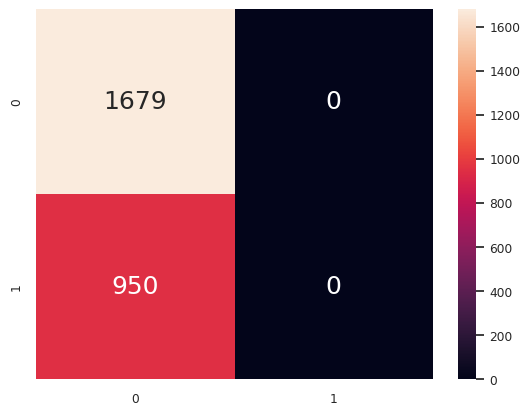

In [ ]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

Using GridSearch CV to find Best Model

In [ ]:
c = c.sample(n=2000, random_state=42)


# Extract Response and Predictors
y = pd.DataFrame(c['Heart Attack Risk'])
X = pd.DataFrame(c.drop('Heart Attack Risk', axis = 1))
# X = pd.DataFrame(a.drop('Heart Attack Risk', axis=1).dropna(subset=['Diet']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train['Heart Attack Risk'].values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [ ]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=2)
0.6285714285714286


In [ ]:
#Random Forest Gen 3
y = pd.DataFrame(c['Heart Attack Risk'])
X = pd.DataFrame(c.drop('Heart Attack Risk', axis = 1))
# X = pd.DataFrame(a.drop('Heart Attack Risk', axis=1).dropna(subset=['Diet']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 2000,  # n_estimators denote number of trees
                                 max_depth =2)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train['Heart Attack Risk'].values.ravel())

RandomForestClassifier(max_depth=2, n_estimators=2000)

Test Data
Accuracy  :	 0.6386458729554964

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1679
           1       0.00      0.00      0.00       950

    accuracy                           0.64      2629
   macro avg       0.32      0.50      0.39      2629
weighted avg       0.41      0.64      0.50      2629


TPR Test :	 0.0
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


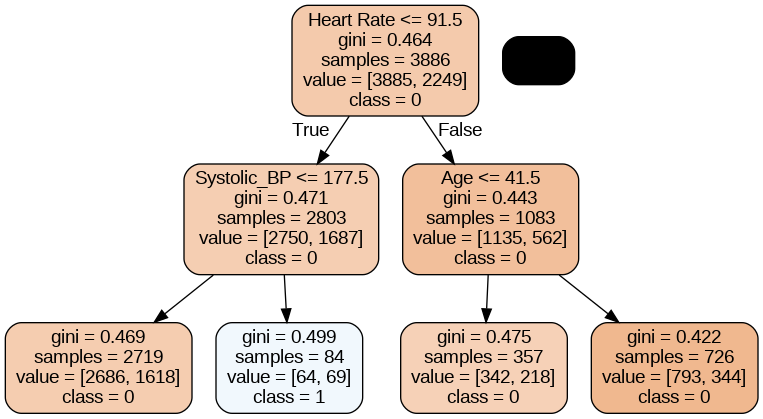

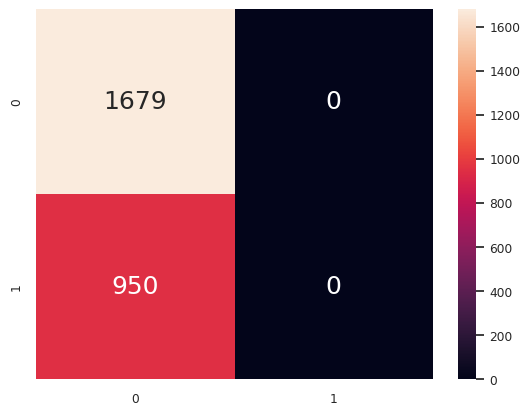

In [ ]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

tree = rforest.estimators_[0]


dot_data = export_graphviz(tree, out_file=None,
                            feature_names=X.columns,
                            class_names=["0", "1"],
                            filled=True, rounded=True)


# Create Graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show the decision tree
Image(graph.create_png())

In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
pip install --upgrade imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
q = a.sample(n=2000, random_state=42)

y = q['Heart Attack Risk']  # Target variable

X = q[['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week','Sedentary Hours Per Day', 'BMI', 'Triglycerides',
       'Systolic_BP', 'Diastolic_BP',"Diabetes","Obesity","Income"]]

**Check the imbalance.**

In [ ]:
y.value_counts(normalize=True) * 100

Heart Attack Risk
0    64.3
1    35.7
Name: proportion, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
y_smote.value_counts(normalize=True) * 100

Heart Attack Risk
0    50.0
1    50.0
Name: proportion, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3)
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 2000,  # n_estimators denote number of trees
                                 max_depth =30)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train)

Test Data
Accuracy  :	 0.6424870466321243

TPR Test :	 0.5974358974358974
TNR Test :	 0.6884816753926701

FPR Test :	 0.31151832460732987
FNR Test :	 0.4025641025641026


<Axes: >

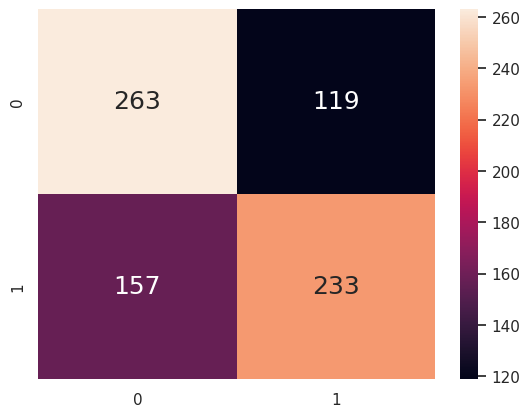

In [ ]:
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

##**K-Nearest Neighbour**

Test Accuracy: 0.607074933434766

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.88      0.74      1691
           1       0.35      0.12      0.18       938

    accuracy                           0.61      2629
   macro avg       0.50      0.50      0.46      2629
weighted avg       0.54      0.61      0.54      2629

Variable :        Income  Systolic_BP  Cholesterol  Medication Use
0     261404          158          208               0
1     285768          165          389               0
2     235282          174          324               1
3     125640          163          383               0
4     160555           91          318               0
...      ...          ...          ...             ...
8758  235420           94          121               1
8759  217881          157          120               0
8760   36998          161          250               0
8761  209943          119          178               1

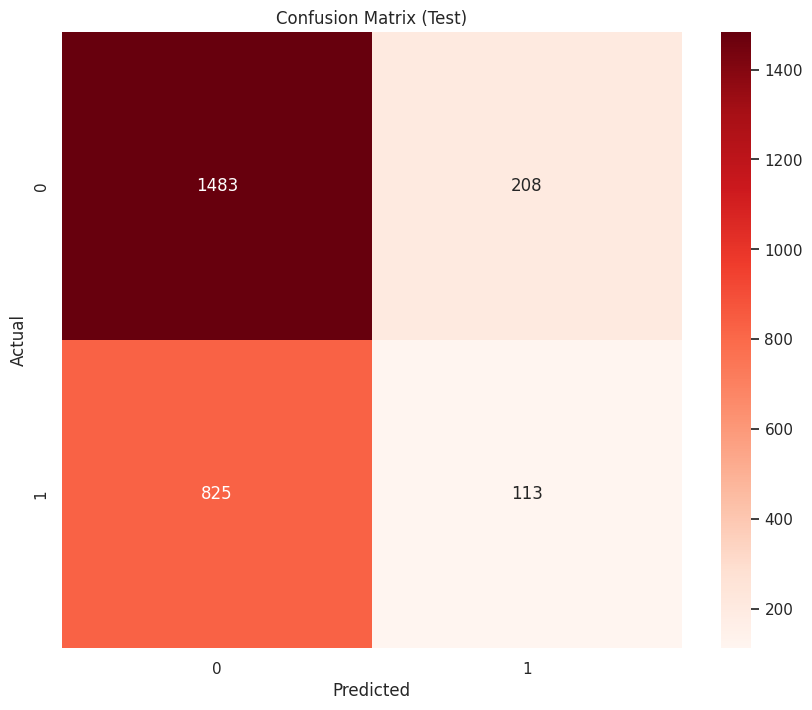

Confusion Matrix for Model (Test):
[[1483  208]
 [ 825  113]]
TPR Test :	 0.12046908315565032
TNR Test :	 0.8769958604376109
FPR Test :	 0.12300413956238912
FNR Test :	 0.8795309168443497



In [ ]:
X = a[['Income','Systolic_BP','Cholesterol', 'Medication Use']]
y = a['Heart Attack Risk']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Random default k value
k = 2

# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_scaled, y_train)

# Predictions on the train set
y_pred_train = knn_classifier.predict(X_train_scaled)
# Predictions on the test set
y_pred_test = knn_classifier.predict(X_test_scaled)

# Evaluate model performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("Variable : ", X)
print("Train data set of :", X_train.shape, y_train.shape)
print("Test data set :", X_test.shape, y_test.shape)

#Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

# Calculate TPR and FPR for test set
TP_test = cm_test[1, 1]
FP_test = cm_test[0, 1]
TN_test = cm_test[0, 0]
FN_test = cm_test[1, 0]

print("Confusion Matrix for Model (Test):")
print(cm_test)
print("TPR Test :\t", (TP_test/(TP_test + FN_test)))
print("TNR Test :\t", (TN_test/(TN_test + FP_test)))
print("FPR Test :\t", (FP_test/(FP_test + TN_test)))
print("FNR Test :\t", (FN_test/(FN_test + TP_test)))

print()



#### Looking for the best n-neighbour value to obtain a higher test accuracy for K-Nearest Neighbour



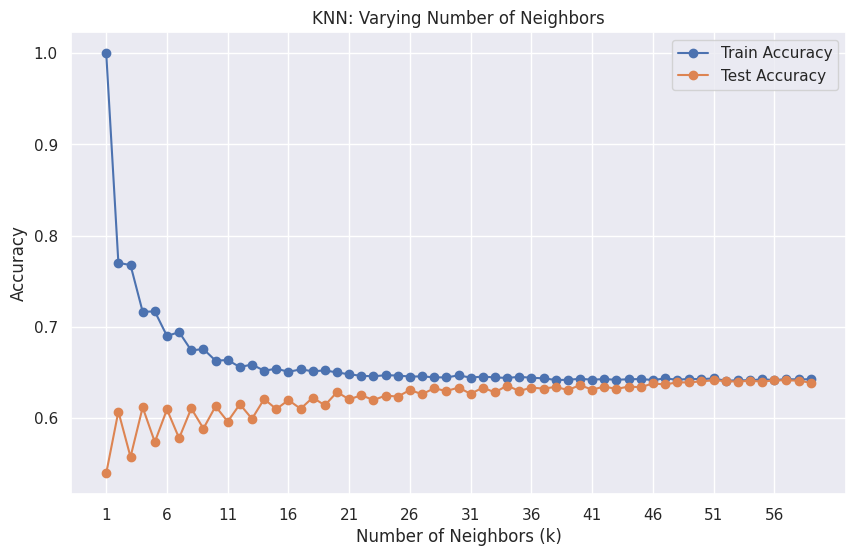

In [ ]:
# Define a range of values for k
k_values = range(1, 60)

# Initialize dictionaries to store train and test accuracy scores for different k values
train_scores = {}
test_scores = {}

# Train KNN classifiers for different k values and evaluate their performance
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_scaled, y_train)

    # Predictions on the train and test sets
    y_pred_train = knn_classifier.predict(X_train_scaled)
    y_pred_test = knn_classifier.predict(X_test_scaled)

    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Store accuracy scores in dictionaries
    train_scores[k] = train_accuracy
    test_scores[k] = test_accuracy

# Plot train and test accuracy scores for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, list(train_scores.values()), label="Train Accuracy", marker='o')
plt.plot(k_values, list(test_scores.values()), label="Test Accuracy", marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN: Varying Number of Neighbors")
plt.legend()
plt.grid(True)
plt.xticks(np.arange(1, 60, step=5))
plt.show()

In [ ]:
# Define parameter grid
X = a[['Income','Systolic_BP','Cholesterol', 'Medication Use']]
y = a['Heart Attack Risk']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': range(1, 60)}

# Initialize cross-validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Retrieve best model
best_knn_classifier = grid_search.best_estimator_

# Evaluate best model on test set
y_pred_test_best = best_knn_classifier.predict(X_test_scaled)
test_accuracy_best = accuracy_score(y_test, y_pred_test_best)

print("Best Model Test Accuracy:", test_accuracy_best)
print("Best Model Parameters:", grid_search.best_params_)


Best Model Test Accuracy: 0.6378851274248764
Best Model Parameters: {'n_neighbors': 46}


Test Accuracy: 0.6378851274248764

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.78      1691
           1       0.34      0.02      0.03       938

    accuracy                           0.64      2629
   macro avg       0.49      0.50      0.40      2629
weighted avg       0.54      0.64      0.51      2629

Variable :        Income  Systolic_BP  Cholesterol  Medication Use
0     261404          158          208               0
1     285768          165          389               0
2     235282          174          324               1
3     125640          163          383               0
4     160555           91          318               0
...      ...          ...          ...             ...
8758  235420           94          121               1
8759  217881          157          120               0
8760   36998          161          250               0
8761  209943          119          178               

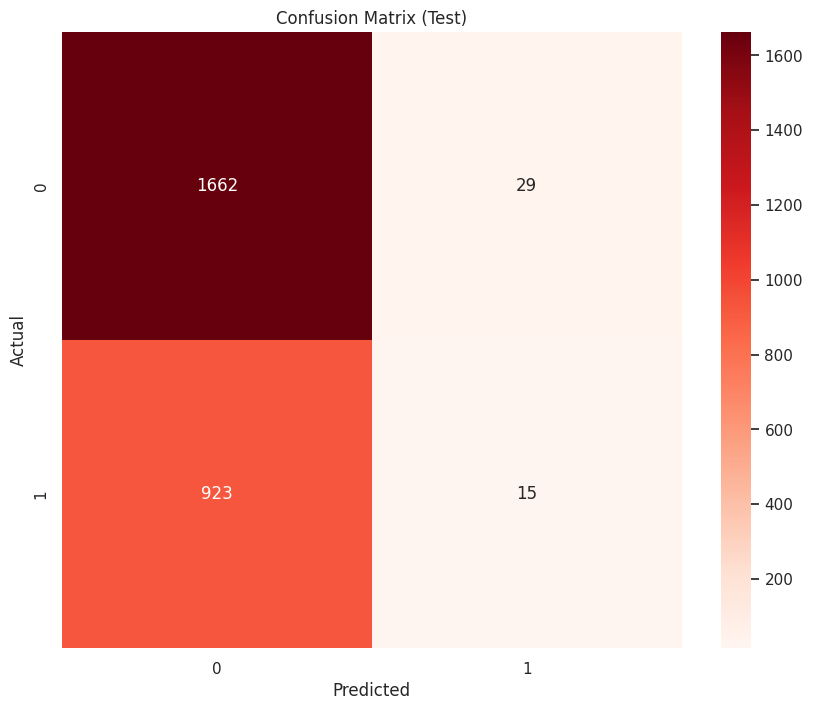

Confusion Matrix for Model (Test):
[[1662   29]
 [ 923   15]]
TPR Test :	 0.015991471215351813
TNR Test :	 0.9828503843879361
FPR Test :	 0.01714961561206387
FNR Test :	 0.9840085287846482



In [ ]:
X = a[['Income','Systolic_BP','Cholesterol', 'Medication Use']]
y = a['Heart Attack Risk']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Best Model Parameter
k = 46

# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred_test = knn_classifier.predict(X_test_scaled)

# Evaluate model performance
test_accuracy = accuracy_score(y_test, y_pred_test_best)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_best))

print("Variable : ", X)
print("Train data set of :", X_train.shape, y_train.shape)
print("Test data set :", X_test.shape, y_test.shape)

#Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test_best)

# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

# Calculate TPR and FPR for test set
TP_test = cm_test[1, 1]
FP_test = cm_test[0, 1]
TN_test = cm_test[0, 0]
FN_test = cm_test[1, 0]

print("Confusion Matrix for Model (Test):")
print(cm_test)
print("TPR Test :\t", (TP_test/(TP_test + FN_test)))
print("TNR Test :\t", (TN_test/(TN_test + FP_test)))
print("FPR Test :\t", (FP_test/(FP_test + TN_test)))
print("FNR Test :\t", (FN_test/(FN_test + TP_test)))

print()



**The best n_neighbour value == 46 which will return a test accuracy of 0.64(2d.p.)**

# Conclusion

After trying out 3 machine learning models, we have come to the conclusion that Random Forest is the model that is best at predicting Heart Attack Risk among individuals as it gives the highest accuracy of 0.6930 and a F1-Score of approximately 0.70. However, these values are not considered high enough. It shows that the current set of data and variables used are not able to accurately predict Heart Attack Risk. However, these are proven to be the variables from each category with the highest correlation to Heart Attack Risk. It reveals that the complexity of factors contributing to heart attack risk and the variables included in our analysis cannot fully capture it.  As such, we believe that further research incorporating advanced modelling techniques and  a broader range of variables may be necessary to gain deeper insights into the complex nature of heart attack risk and improve the prediction accuracy. Exploring additional variables, collecting more comprehensive datasets, or experimenting with different feature engineering techniques could potentially improve predictive performance.